<a href="https://colab.research.google.com/github/PrincipledProgrammer/ULTIMATE4/blob/Mangalam-Sharma/image_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/subject_data.csv")

/tmp/ipython-input-3488947334.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/subject_data.csv")


In [5]:
cols = list(data.columns)
cols.remove('target')
cols.remove('isic_id')

target_id = data.drop(cols,axis = 1)
target_id.set_index('isic_id',inplace=True)

In [6]:
!pip install h5py

Extract the first target = 1 image from data for applying transformations


In [10]:
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import cv2

file_path = "/content/drive/MyDrive/images.hdf5"
isic_codes = data['isic_id']

target_1 = []

with h5py.File(file_path, "r") as hdf:
    for i in isic_codes:
        data_ = hdf[i]

        if data_.shape == () and data_.dtype.kind == 'S':
            image_bytes = data_[()]
            img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            img_np = np.array(img)

            if target_id.loc[i].values == 1:
              target_1.append(img_np)
            if len(target_1) == 1:
              break



Attempted Image transformations

Color Constancy


In [14]:
import cv2
import numpy as np


def color_constancy(img_rgb):

    img_float = img_rgb.astype(np.float32)
    mean_r = np.mean(img_float[:, :, 0])
    mean_g = np.mean(img_float[:, :, 1])
    mean_b = np.mean(img_float[:, :, 2])
    mean_gray = (mean_r + mean_g + mean_b) / 3
    img_float[:, :, 0] *= mean_gray / mean_r
    img_float[:, :, 1] *= mean_gray / mean_g
    img_float[:, :, 2] *= mean_gray / mean_b
    return np.clip(img_float, 0, 255).astype(np.uint8)



(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

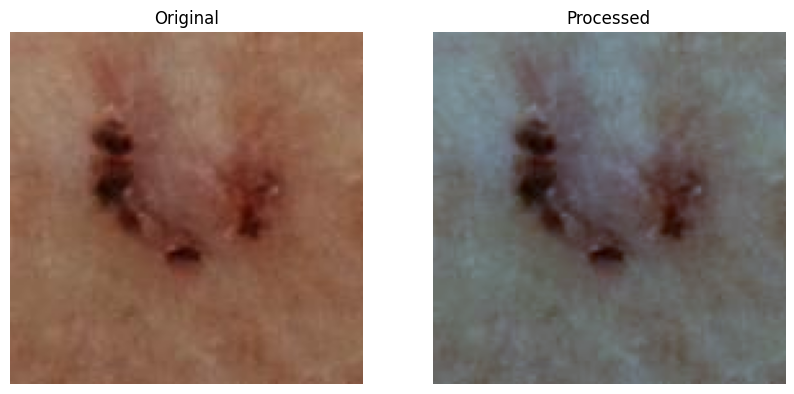

In [15]:
func = color_constancy
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')


Increase Sharpness

In [17]:
import cv2
import numpy as np

def increase_sharpness(img_rgb, amount=1.5, kernel_size=(5, 5)):

    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    blurred = cv2.GaussianBlur(img_rgb, kernel_size, 0)

    sharpened = cv2.addWeighted(img_rgb, 1 + amount, blurred, -amount, 0)

    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

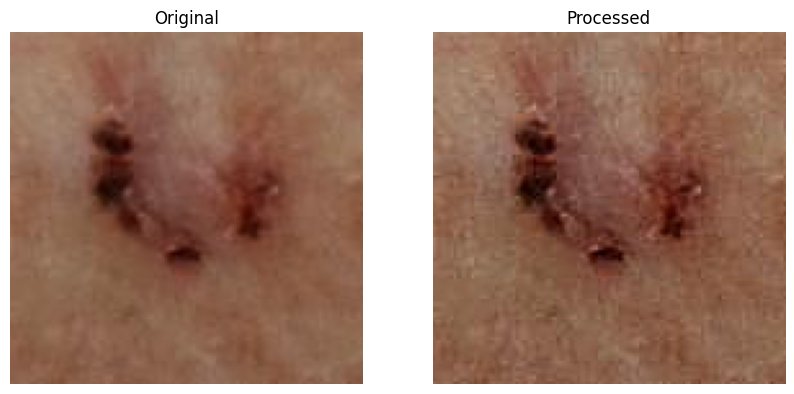

In [18]:
func = increase_sharpness
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')


Applies Histogram Equalization

In [20]:
# Applies CLAHE (a form of Histogram Equalization)
def apply_CLAHE(img_rgb, clip_limit=2.0, tile_grid_size=(8, 8)):
    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_eq = clahe.apply(l)

    lab_eq = cv2.merge((l_eq, a, b))

    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

    return img_eq

(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

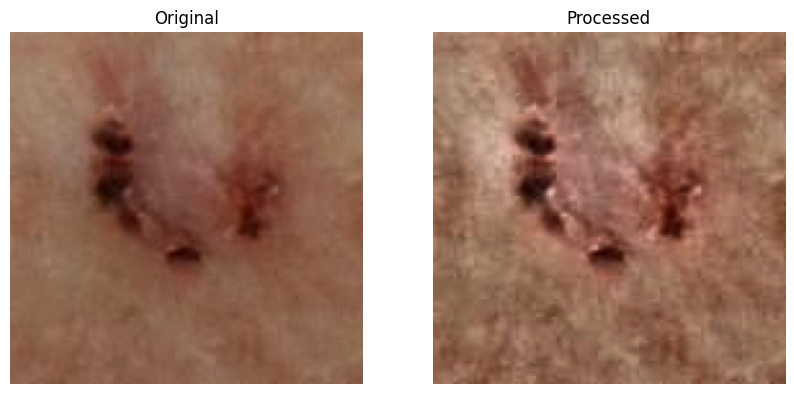

In [19]:
func = apply_CLAHE
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')


Lesion extraction through Edge Detection

In [ ]:
import cv2
import numpy as np

#Function to detect edges through three methods "Sobel", "Canny" ,"Laplacian"
def edge_detection(img_rgb, method="sobel"):

    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    method = method.lower()

    if method == "sobel":
        # Compute Sobel gradients in X and Y
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        # Convert gradients to absolute and combine
        sobel = cv2.magnitude(grad_x, grad_y)
        edges = np.uint8(np.clip(sobel, 0, 255))

    elif method == "canny":
        # Canny edge detector
        edges = cv2.Canny(gray, threshold1=100, threshold2=200)

    elif method == "laplacian":
        # Laplacian edge detection
        lap = cv2.Laplacian(gray, cv2.CV_64F)
        edges = np.uint8(np.absolute(lap))

    elif method == "prewitt":

        kernelx = np.array([[ -1, 0, 1],
                            [ -1, 0, 1],
                            [ -1, 0, 1]])
        kernely = np.array([[ 1, 1, 1],
                            [ 0, 0, 0],
                            [-1,-1,-1]])

        grad_x = cv2.filter2D(gray, -1, kernelx)
        grad_y = cv2.filter2D(gray, -1, kernely)
        prewitt = cv2.magnitude(grad_x.astype(np.float32), grad_y.astype(np.float32))
        edges = np.uint8(np.clip(prewitt, 0, 255))

    else:
        raise ValueError("Invalid method. Choose from: sobel, canny, laplacian, prewitt.")

    return edges

(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

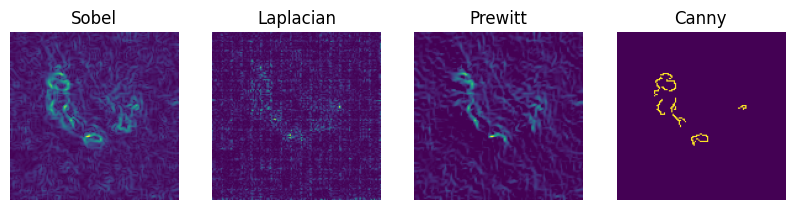

In [24]:
func = edge_detection

img_np = target_1[0]
img_processed1 = func(img_np)
img_processed4 = func(img_np,'canny')
img_processed2 = func(img_np,'laplacian')
img_processed3 = func(img_np,'prewitt')


plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_processed1)
plt.title("Sobel")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_processed2)
plt.title("Laplacian")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_processed3)
plt.title("Prewitt")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_processed4)
plt.title("Canny")
plt.axis('off')

With CLAHE and a higher threshold for Canny edge detection


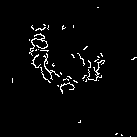


 Without CLAHE and a lower threshold for Canny edge detection


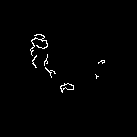

In [25]:
from google.colab.patches import cv2_imshow
import cv2

# Canny Edge Detection
edges_withCLAHE = cv2.Canny(image=apply_CLAHE(target_1[0]), threshold1=155, threshold2=200)
edges_withoutCLAHE = cv2.Canny(image=(target_1[0]), threshold1=100, threshold2=200)

# Display Canny Edge Detection Image
print("With CLAHE and a higher threshold for Canny edge detection")
cv2_imshow( edges_withCLAHE)
print('\n',"Without CLAHE and a lower threshold for Canny edge detection")
cv2_imshow( edges_withoutCLAHE)

Hair Removal

In [ ]:
import cv2
import numpy as np

# Applies dull razor algorithm for hair removal
def dull_razor_hair_removal(img_rgb, kernel_size=17, thresh_val=10, inpaint_radius=1):
    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    diff = cv2.absdiff(closed, gray)

    _, hair_mask = cv2.threshold(diff, thresh_val, 255, cv2.THRESH_BINARY)

    inpaint = cv2.inpaint(img_rgb, hair_mask, inpaint_radius, cv2.INPAINT_TELEA)

    return inpaint

(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

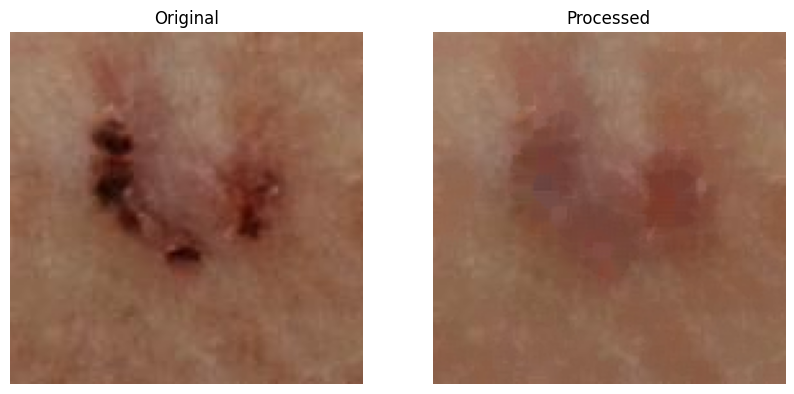

In [26]:
func = dull_razor_hair_removal
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')

Drawing contours for lesion extraction

In [12]:
import cv2
import numpy as np
from skimage.exposure import match_histograms


def histogram_match_to_reference(img_rgb, ref_rgb = target_1[0]):
    matched = match_histograms(img_rgb, ref_rgb, channel_axis=-1)
    return matched.astype(np.uint8)

def extract_lesion_mask(img_rgb):

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(img_rgb, -1, kernel)
    gau_blur = cv2.GaussianBlur(sharpened_image, (5, 5), 1)

    # Preprocessing
    blurred = cv2.GaussianBlur(img_rgb, (5, 5), 1)

    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    hsv[:, :, 0] = hsv[:, :, 0] * 0.8
    hsv[:, :, 1] = hsv[:, :, 1] * 2
    hsv[:, :, 2] = hsv[:, :, 2] * 0.8
    hsv_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(hsv_rgb, cv2.COLOR_RGB2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, 50, 300)

    edges = cv2.dilate(edges, None, iterations=1)
    edges = cv2.erode(edges, None, iterations=1)

    _, lesion_mask = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return lesion_mask, contours

def draw_contours(img_rgb):

    lesion_mask, contours = extract_lesion_mask(img_rgb)
    img_with_contours = img_rgb.copy()
    cv2.drawContours(img_with_contours, contours, -1, (255, 255, 0), 2)
    return img_with_contours

(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

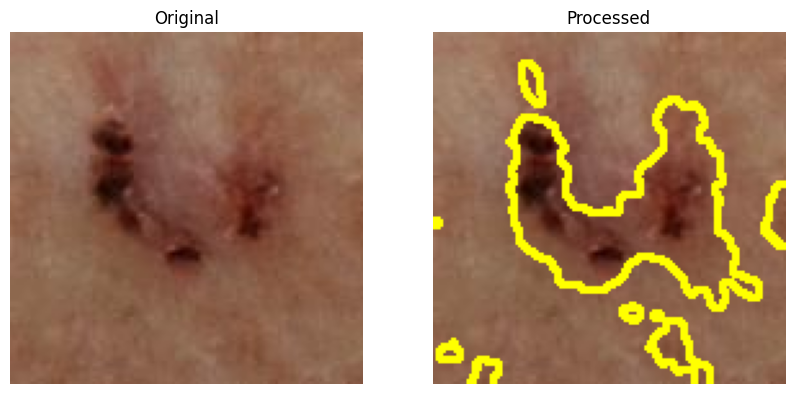

In [27]:
func = draw_contours
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')


Lesion Extraction throug edge detection

In [29]:
def segment_lesion_and_blacken_background(image_rgb): # lesion extraction


    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)


    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    kernel_small = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=2)

    kernel_large = np.ones((6, 6), np.uint8)
    dilate = cv2.dilate(opening, kernel_large, iterations=3)

    blur = cv2.blur(dilate, (15, 15))

    _, thresh2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return image_rgb
    cnt = max(contours, key=cv2.contourArea)


    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    lesion_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    return (lesion_only)

(np.float64(-0.5), np.float64(136.5), np.float64(136.5), np.float64(-0.5))

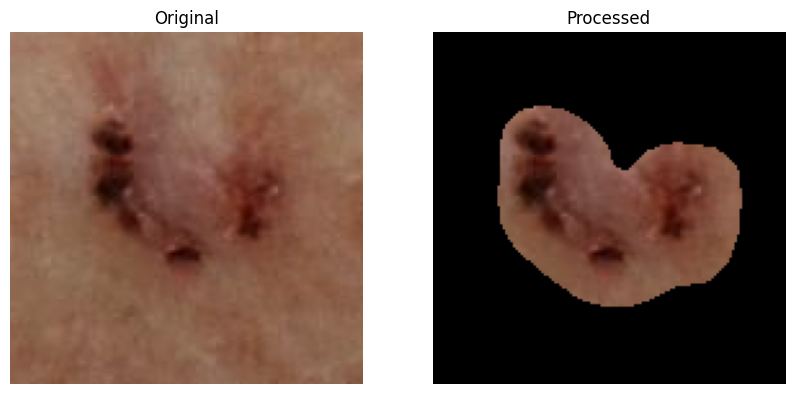

In [30]:
func = segment_lesion_and_blacken_background
img_np = target_1[0]
img_processed = func(img_np)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_processed)
plt.title("Processed")
plt.axis('off')


Transformation Chosen

In [ ]:
from PIL import Image
import cv2
import numpy as np

def transform_to_Image(func):

  def wrapper(img):
    return Image.fromarray(func(img))

  return wrapper

@transform_to_Image
def resize_image(img_rgb, target_size=(224, 224)):

    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
    return resized

@transform_to_Image
def normalize_image(img_rgb):

    if img_rgb is None or img_rgb.size == 0:
        raise ValueError("Empty image provided")

    return img_rgb.astype(np.float32) / 255.0


@transform_to_Image
def apply_gaussian_blur(img_rgb, ksize=(5, 5), sigma=1):
    blurred = cv2.GaussianBlur(img_rgb, ksize, sigma)
    return (blurred)

@transform_to_Image
def segment_lesion_and_blacken_background(image_rgb): # lesion extraction


    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)


    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    kernel_small = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=2)

    kernel_large = np.ones((6, 6), np.uint8)
    dilate = cv2.dilate(opening, kernel_large, iterations=3)

    blur = cv2.blur(dilate, (15, 15))

    _, thresh2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return image_rgb
    cnt = max(contours, key=cv2.contourArea)


    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    lesion_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    return (lesion_only)




In [ ]:
import cv2

class Pipeline:
  def __init__(self):
    self.functions = []

  def apply(self,img):
    for func in self.functions:
      img = func(img)
    return img

  def add_function(self,func):
    self.functions.append(func)

  def remove_function(self,func):
    self.functions.remove(func)


pipeline = Pipeline()

pipeline.add_function(resize_image)
pipeline.add_function(normalize_image)
pipeline.add_function(segment_lesion_and_blacken_background)
